In [2]:
%run ../../main.py

In [22]:
%matplotlib inline

import pandas as pd
import pyarc
import pyarc.utils.plotting as utils

from pyarc import TransactionDB
from pyarc.qcba.data_structures import QuantitativeDataFrame

from pyids.ids_classifier import mine_CARs

In [48]:
import pandas


class LiteralCache:
    """class which stores literals
    and corresponding truth values
    e.g. [
        "food=banana": [True, True, False, False, True],
        "food=apple" : [True, True, True, True, False]
    ]
    
    """
    
    def __init__(self):
        self.__cache = {}

    def insert(self, literal, truth_values):
        self.__cache[literal] = truth_values
        
    def get(self, literal):
        return self.__cache[literal]
        
    def __contains__(self, literal):
        """function for using in
        on LiteralCache object
        """
        
        return literal in self.__cache.keys()



    import pandas
import numpy as np


class QuantitativeDataFrame:
    
    def __init__(self, dataframe):
        if type(dataframe) != pandas.DataFrame:
            raise Exception("type of dataframe must be pandas.dataframe")
        
        
        self.__dataframe = dataframe
        
        # sorted and unique columns of the dataframe
        # saved as a numpy array
        self.__preprocessed_columns = self.__preprocess_columns(dataframe)
        
        
        # literal cache for computing rule statistics
        # - support and confidence
        self.__literal_cache = LiteralCache()

        # so that it doesn't have to be computed over and over
        self.size = dataframe.index.size
        
        
    @property
    def dataframe(self):
        return self.__dataframe
    
    
    def column(self, colname):
        return self.__preprocessed_columns[colname]
    
    
    def mask(self, vals):
        return self.__dataframe[vals]
    
    
    def find_covered_by_antecedent_mask(self, antecedent):
        """
        returns:
            mask - an array of boolean values indicating which instances
            are covered by antecedent
        """
        
        # todo: compute only once to make function faster
        dataset_size = self.__dataframe.index.size

        cummulated_mask = np.ones(dataset_size).astype(bool)
        
        for literal in antecedent:
            attribute, interval = literal
            
            # the column that concerns the
            # iterated attribute
            # instead of pandas.Series, grab the ndarray
            # using values attribute
            relevant_column = self.__dataframe[[attribute]].values.reshape(dataset_size)
            
            # this tells us which instances satisfy the literal
            current_mask = self.get_literal_coverage(literal, relevant_column)
            
            # add cummulated and current mask using logical AND
            cummulated_mask &= current_mask

        return cummulated_mask
    
    
    def find_covered_by_literal_mask(self, literal):
        """
        returns:
            mask - an array of boolean values indicating which instances
            are covered by literal
        """
        
        for literal in rule.antecedent:
            attribute, interval = literal
            
            # the column that concerns the
            # iterated attribute
            # instead of pandas.Series, grab the ndarray
            # using values attribute
            relevant_column = self.__dataframe[[attribute]].values.reshape(dataset_size)
            
            # this tells us which instances satisfy the literal
            current_mask = self.get_literal_coverage(literal, relevant_column)
            
            # add cummulated and current mask using logical AND
            cummulated_mask &= current_mask
    
    
    def find_covered_by_rule_mask(self, rule):
        """
        returns:
            covered_by_antecedent_mask:
                - array of boolean values indicating which
                dataset rows satisfy antecedent
                
            covered_by_consequent_mask:
                - array of boolean values indicating which
                dataset rows satisfy conseqeunt
        """
        
        dataset_size = self.__dataframe.index.size
        
        # initialize a mask filled with True values
        # it will get modified as futher literals get
        # tested
        
        # for optimization - create cummulated mask once
        # in constructor
        cummulated_mask = np.array([True] * dataset_size)
        
        for literal in rule.antecedent:
            attribute, interval = literal
            
            # the column that concerns the
            # iterated attribute
            # instead of pandas.Series, grab the ndarray
            # using values attribute
            relevant_column = self.__dataframe[[attribute]].values.reshape(dataset_size)
            
            # this tells us which instances satisfy the literal
            current_mask = self.get_literal_coverage(literal, relevant_column)
            
            # add cummulated and current mask using logical AND
            cummulated_mask &= current_mask
            
            
        
        instances_satisfying_antecedent_mask = cummulated_mask
        instances_satisfying_consequent_mask = self.__get_consequent_coverage_mask(rule)
        print(instances_satisfying_consequent_mask)
        
        instances_satisfying_consequent_mask = instances_satisfying_consequent_mask.reshape(dataset_size)
        
        return instances_satisfying_antecedent_mask, instances_satisfying_consequent_mask
        
        
    
    def calculate_rule_statistics(self, rule):
        """calculates rule's confidence and
        support using efficient numpy functions
        
        
        returns:
        --------
        
            support:
                float
            
            confidence:
                float
        """
        
        dataset_size = self.__dataframe.index.size
        
        # initialize a mask filled with True values
        # it will get modified as futher literals get
        # tested
        
        # for optimization - create cummulated mask once
        # in constructor
        cummulated_mask = np.array([True] * dataset_size)
        
        for literal in rule.antecedent:
            attribute, interval = literal
            
            # the column that concerns the
            # iterated attribute
            # instead of pandas.Series, grab the ndarray
            # using values attribute
            relevant_column = self.__dataframe[[attribute]].values.reshape(dataset_size)
            
            # this tells us which instances satisfy the literal
            current_mask = self.get_literal_coverage(literal, relevant_column)
            
            # add cummulated and current mask using logical AND
            cummulated_mask &= current_mask
            
        
        instances_satisfying_antecedent = self.__dataframe[cummulated_mask].index
        instances_satisfying_antecedent_count = instances_satisfying_antecedent.size
        
        # using cummulated mask to filter out instances that satisfy consequent
        # but do not satisfy antecedent
        instances_satisfying_consequent_mask = self.__get_consequent_coverage_mask(rule)
        instances_satisfying_consequent_mask = instances_satisfying_consequent_mask.reshape(dataset_size)
        
        instances_satisfying_consequent_and_antecedent = self.__dataframe[
            instances_satisfying_consequent_mask & cummulated_mask
        ].index
        
        instances_satisfying_consequent_and_antecedent_count = instances_satisfying_consequent_and_antecedent.size
        instances_satisfying_consequent_count = self.__dataframe[instances_satisfying_consequent_mask].index.size
        
        # instances satisfying consequent both antecedent and consequent 

        support = instances_satisfying_antecedent_count / dataset_size
        
        confidence = 0
        if instances_satisfying_antecedent_count != 0:
            confidence = instances_satisfying_consequent_and_antecedent_count / instances_satisfying_antecedent_count
        
        return support, confidence
    
    
    def __get_consequent_coverage_mask(self, rule):
        consequent = rule.consequent
        attribute, value = consequent
        
        class_column = self.__dataframe[[attribute]].values
        class_column = class_column.astype(str)
        
        literal_key = "{}={}".format(attribute, value)

        mask = []
        
        if literal_key in self.__literal_cache:
            mask = self.__literal_cache.get(literal_key)
        else:
            mask = class_column == value
        
        return mask
    
    
    def get_literal_coverage(self, literal, values):
        """returns mask which describes the instances that
        satisfy the interval
        
        function uses cached results for efficiency
        """
        
        if type(values) != np.ndarray:
            raise Exception("Type of values must be numpy.ndarray")
            
        mask = []
        
        attribute, interval = literal
        
        literal_key = "{}={}".format(attribute, interval)
        
        # check if the result is already cached, otherwise
        # calculate and save the result
        if literal_key in self.__literal_cache:
            mask = self.__literal_cache.get(literal_key)
        else:
            mask = None

            if type(interval) == str:
                mask = np.array([ val == interval for val in values ])
            else:
                mask = interval.test_membership(values)
            
            self.__literal_cache.insert(literal_key, mask)
            
        # reshape mask into single dimension
        mask = mask.reshape(values.size)
            
        return mask
    
    
    def __preprocess_columns(self, dataframe):
        
        # covert to dict
        # column -> list
        # need to convert it to numpy array
        dataframe_dict = dataframe.to_dict(orient="list")
        
        dataframe_ndarray = {}
        
        
        for column, value_list in dataframe_dict.items():
            transformed_list = np.sort(np.unique(value_list))
            dataframe_ndarray[column] = transformed_list
            
        return dataframe_ndarray
        

In [49]:
df = pd.read_csv("C:/code/python/pyIDS/data/titanic.csv")

quant_df = QuantitativeDataFrame(df)
cars = mine_CARs(df, 20)

Running apriori with setting: confidence=0.5, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=4
Rule count: 52, Iteration: 1
Increasing maxlen 4
Running apriori with setting: confidence=0.5, support=0.0, minlen=2, maxlen=4, MAX_RULE_LEN=4
Rule count: 76, Iteration: 2
Decreasing confidence to 0.45
Running apriori with setting: confidence=0.45, support=0.0, minlen=2, maxlen=4, MAX_RULE_LEN=4
Rule count: 76, Iteration: 3
Decreasing confidence to 0.4
Running apriori with setting: confidence=0.4, support=0.0, minlen=2, maxlen=4, MAX_RULE_LEN=4
Rule count: 76, Iteration: 4
Decreasing confidence to 0.35000000000000003
Running apriori with setting: confidence=0.35000000000000003, support=0.0, minlen=2, maxlen=4, MAX_RULE_LEN=4
Rule count: 76, Iteration: 5
Decreasing confidence to 0.30000000000000004
Running apriori with setting: confidence=0.30000000000000004, support=0.0, minlen=2, maxlen=4, MAX_RULE_LEN=4
Rule count: 76, Iteration: 6
Decreasing confidence to 0.25000000000000006
Running apriori

In [50]:
car0 = cars[0]

car0

CAR {Passenger_Cat=2nd_class,Age_Cat=child} => {Died=0} sup: 0.01 conf: 1.00 len: 3, id: 606

In [51]:
quant_df.find_covered_by_rule_mask(car0)

[[False]
 [False]
 [False]
 ...
 [False]
 [ True]
 [ True]]


(array([False, False, False, ..., False,  True, False]),
 array([False, False, False, ..., False,  True,  True]))

In [39]:
utils.plot_rules(rules)

NameError: name 'rules' is not defined

In [31]:
rules

[CAR {a-list-celebrities=<0;2)} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 160,
 CAR {estimated-budget=<250;300)} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 122,
 CAR {a-list-celebrities=<4;6),estimated-budget=<0;50)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142,
 CAR {a-list-celebrities=<6;8)} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 119,
 CAR {a-list-celebrities=<4;6),estimated-budget=<100;150)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 128,
 CAR {a-list-celebrities=<4;6),estimated-budget=<150;200)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 134,
 CAR {estimated-budget=<200;250)} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 127,
 CAR {estimated-budget=<0;50)} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 147,
 CAR {a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id: 151]

In [32]:
quant_rules = [ QuantClassAssociationRule(r) for r in rules ]

In [33]:
quant_rules

[CAR {a-list-celebrities=<0.0;2.0)} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 160,
 CAR {estimated-budget=<250.0;300.0)} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 122,
 CAR {a-list-celebrities=<4.0;6.0),estimated-budget=<0.0;50.0)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142,
 CAR {a-list-celebrities=<6.0;8.0)} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 119,
 CAR {a-list-celebrities=<4.0;6.0),estimated-budget=<100.0;150.0)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 128,
 CAR {a-list-celebrities=<4.0;6.0),estimated-budget=<150.0;200.0)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 134,
 CAR {estimated-budget=<200.0;250.0)} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 127,
 CAR {estimated-budget=<0.0;50.0)} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 147,
 CAR {a-list-celebrities=<4.0;6.0)} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id: 1

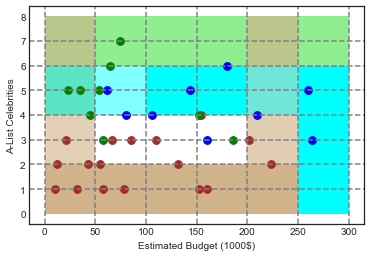

In [34]:
utils.plot_quant_rules(quant_rules)

In [35]:
rr = RuleReffiter(movies_undiscr_txns)
rr.refit(quant_rules)

[CAR {a-list-celebrities=<1.0;1.0>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 160,
 CAR {estimated-budget=<260.0;264.0>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 122,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<10.0;45.0>} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142,
 CAR {a-list-celebrities=<6.0;7.0>} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 119,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<106.0;143.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 128,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<152.0;186.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 134,
 CAR {estimated-budget=<202.0;223.0>} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 127,
 CAR {estimated-budget=<10.0;45.0>} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 147,
 CAR {a-list-celebrities=<4.0;5.0>} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id:

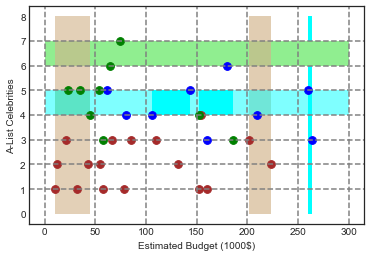

In [36]:
utils.plot_quant_rules(quant_rules)

In [37]:
ds = movies_undiscr_txns

In [40]:
import pandas
import numpy as np
from pyarc.qcba.interval import Interval
from pyarc.qcba.quant_rule import QuantClassAssociationRule


def find_covered_by_literal(literal, dataset):
    dataset_len = len(dataset)
    
    attribute, interval = literal
    
    current_column = dataset[[attribute]]
        
    satisfying_mask = interval.test_membership(current_column).reshape(dataset_len)
        
    instances_satisfying_antecedent = dataset[satisfying_mask]
    
    return instances_satisfying_antecedent


def find_covered_by_literals(literals, dataset):
    current_subset = dataset
    
    for literal in literals:
        current_subset = find_covered_by_literal(literal, current_subset)
        
    return current_subset


def calculate_rule_statistics(consequent, subset, dataset_len):
    attribute, value = consequent
    
    # satisfying cosequent
    subset_conseq = subset[[attribute]] == value
    
    support_abs = len(subset)
    support = support_abs / dataset_len
    confidence = len(subset_conseq) / support_abs
    
    return support, confidence
    


def find_covered_by_r(qrule, dataset):
    if type(qrule) != QuantClassAssociationRule:
        raise Exception("type of qrule must be QuantClassAssociationRule")
    
    if type(dataset) != pandas.DataFrame:
        raise Exception("type of dataset must be: pandas.DataFrame")
    
    
    dataset_len = len(dataset)
    
    current_mask = np.array([True] * dataset_len)
    
    
    for attribute, interval in qrule.new_antecedent:
        current_column = dataset[[attribute]]
        
        satisfying_mask = interval.test_membership(current_column).reshape(dataset_len)
        
        current_mask &= satisfying_mask
        
    
    instances_satisfying_antecedent = dataset[current_mask]
    
    return instances_satisfying_antecedent



    
        
def find_correctly_covered(qrule, dataset):
    if type(qrule) != QuantClassAssociationRule:
        raise Exception("type of qrule must be QuantClassAssociationRule")
    
    if type(dataset) != pandas.DataFrame:
        raise Exception("type of dataset must be: pandas.DataFrame")
        
        
    instances_satisfying_antecedent = find_covered_by_r(qrule, dataset)
    
    class_name, class_value = qrule.rule.consequent
    
    # mask of rules which satisfy both antecedent
    # and cosequent
    mask = instances_satisfying_antecedent[[class_name]].values == class_value
    
    instances_satisfying_consequent = instances_satisfying_antecedent[mask]
    
    # calculate_rule_statistics
    dataset_len = len(dataset)
    support_abs = len(instances_satisfying_antecedent)
    support = support_abs / dataset_len
    confidence = len(instances_satisfying_consequent) / support_abs
    
    
    return instances_satisfying_consequent, support, confidence
        
        

def trim_rule(qrule, dataset):
    if type(qrule) != QuantClassAssociationRule:
        raise Exception("type of qrule must be QuantClassAssociationRule")
    
    if type(dataset) != pandas.DataFrame:
        raise Exception("type of dataset must be: pandas.DataFrame")
        
    correctly_covered_by_r, _, _ = find_correctly_covered(qrule, dataset)
    antecedent = qrule.new_antecedent
    
    for idx, literal in enumerate(antecedent):
        
        attribute, value = literal
        current_column = correctly_covered_by_r[[attribute]].values
            
        if not current_column.any():
            continue

        minv = np.asscalar(min(current_column))
        maxv = np.asscalar(max(current_column))
        
        new_interval = Interval.from_scalars(minv, maxv, True, True)
        
        antecedent[idx] = attribute, new_interval
    
    return qrule


def trim_rules(rules, dataset):
    return [ trim_rule(r, dataset) for r in rules ]

        
        
        
        
trim_rules(quant_rules, ds)

[CAR {a-list-celebrities=<1.0;1.0>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 160,
 CAR {estimated-budget=<260.0;264.0>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 122,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<23.0;45.0>} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142,
 CAR {a-list-celebrities=<6.0;7.0>} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 119,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<106.0;143.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 128,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<152.0;186.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 134,
 CAR {estimated-budget=<202.0;223.0>} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 127,
 CAR {estimated-budget=<10.0;43.0>} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 147,
 CAR {a-list-celebrities=<4.0;5.0>} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id:

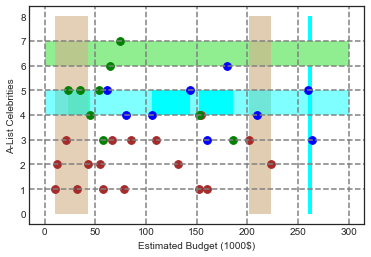

In [41]:
utils.plot_quant_rules(quant_rules)

In [42]:
def produce_combinations(array):
    arr_len = len(array)
    
    for i in range(arr_len):
        combination = array[0:i] + array[i+1:arr_len]
        
        yield combination
    
#a = [1, 2, 3, 4, 5, 6]    
#list(produce_combinations(a))    


def prune_literals(qrule, dataset):
    attr_removed = False
    
    literals = qrule.new_antecedent
    consequent = qrule.rule.consequent
    dataset_len = len(dataset)
    
    current_conf = qrule.rule.confidence
    
    if len(literals) < 1:
        return qrule
    
    while True:
        for literals_combination in produce_combinations(literals):
            if not literals_combination:
                continue
                
            antecedent_covered = find_covered_by_literals(literals_combination, dataset)
            support, confidence = calculate_rule_statistics(consequent, antecedent_covered, dataset_len)
            
            if confidence > qrule.rule.confidence:
                qrule.rule.support = support
                qrule.rule.confidence = confidence
                
                qrule.new_antecedent = literals_combination
                
                attr_removed = True
                break
        
        if attr_removed == False:
            break
    
[ prune_literals(qr, ds) for qr in quant_rules ]

quant_rules

[CAR {a-list-celebrities=<1.0;1.0>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 160,
 CAR {estimated-budget=<260.0;264.0>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 122,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<23.0;45.0>} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142,
 CAR {a-list-celebrities=<6.0;7.0>} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 119,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<106.0;143.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 128,
 CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<152.0;186.0>} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 134,
 CAR {estimated-budget=<202.0;223.0>} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 127,
 CAR {estimated-budget=<10.0;43.0>} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 147,
 CAR {a-list-celebrities=<4.0;5.0>} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id:

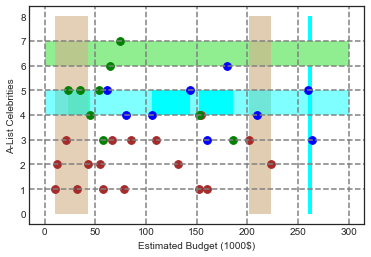

In [44]:
utils.plot_quant_rules(quant_rules)

In [47]:
r1 = rules[2]

r1

CAR {a-list-celebrities=<4;6),estimated-budget=<0;50)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142

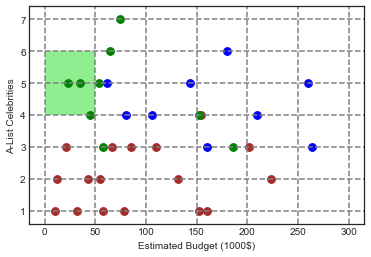

In [49]:
utils.plot_rules([r1])

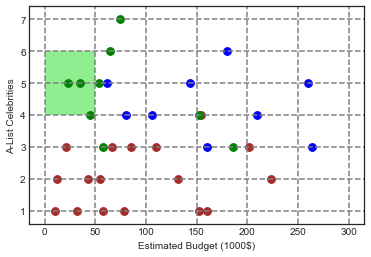

In [53]:
qr1 = QuantClassAssociationRule(r1)

utils.plot_quant_rules([qr1])

In [56]:
from pyarc.qcba.interval import Interval

qr1.new_antecedent[1] = "estimated-budget", Interval("<0.0;150>")

qr1

CAR {a-list-celebrities=<4.0;6.0),estimated-budget=<0.0;150.0>} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142

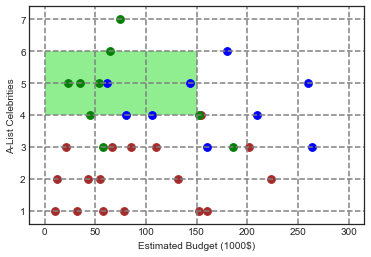

In [57]:
utils.plot_quant_rules([qr1])

In [58]:
rr.refit([qr1])

[CAR {a-list-celebrities=<4.0;5.0>,estimated-budget=<10.0;143.0>} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 142]

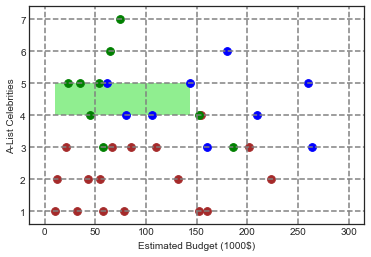

In [59]:
utils.plot_quant_rules([qr1])

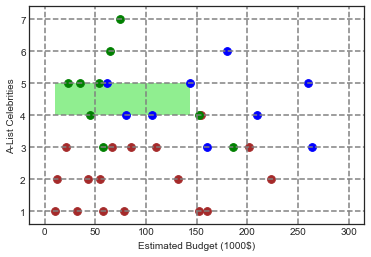

In [65]:
prune_literals(qr1, ds)

qr1

utils.plot_quant_rules([qr1])

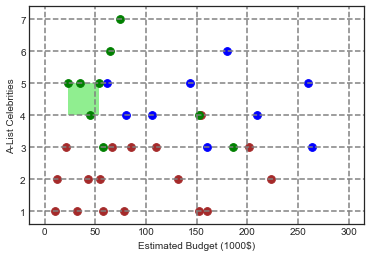

In [67]:
trim_rule(qr1, ds)

qr1

utils.plot_quant_rules([qr1])